In [5]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.optim as optim
import torch.nn as nn
import cv2
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
# Change this to work on your machine
rootPath = '/Users/cameronswapp/Documents/STAT5810_ML/rapid-detection-collection/'

In [7]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cpu


In [8]:
# Function to read a batch from a json and return the image and mask in a format usable by the SAM2 model
def read_batch(data, index):
    with open(data[index], 'r') as f:
        json_obj = json.load(f)
    image = cv2.imread(rootPath + json_obj['image'])
    mask = np.load(rootPath + json_obj['map'])
    return image, mask

images_dir = rootPath + 'jsons'
data = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.json'))]

# Split the data into training and testing sets
indices = range(len(data))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_data = [data[i] for i in train_indices]
test_data = [data[i] for i in test_indices]

In [9]:
# Import and load the SAM2 model (using the tiny version)
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)

optimizer = optim.Adam(params=sam2_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss() 

# Example Without Training

In [10]:
# Use the first image from the test set as an example
img, mask = read_batch(test_data, 0)

# Function to predict the mask of an image
def predictMask(img, predictor, input_point = np.empty((0, 2)), input_label = np.empty((0,), dtype=int)):    
    predictor.set_image(img)
    pred_masks, scores, logits = predictor.predict(
        point_coords = input_point,
        point_labels = input_label,
        multimask_output = False
     )
    return pred_masks, scores, logits

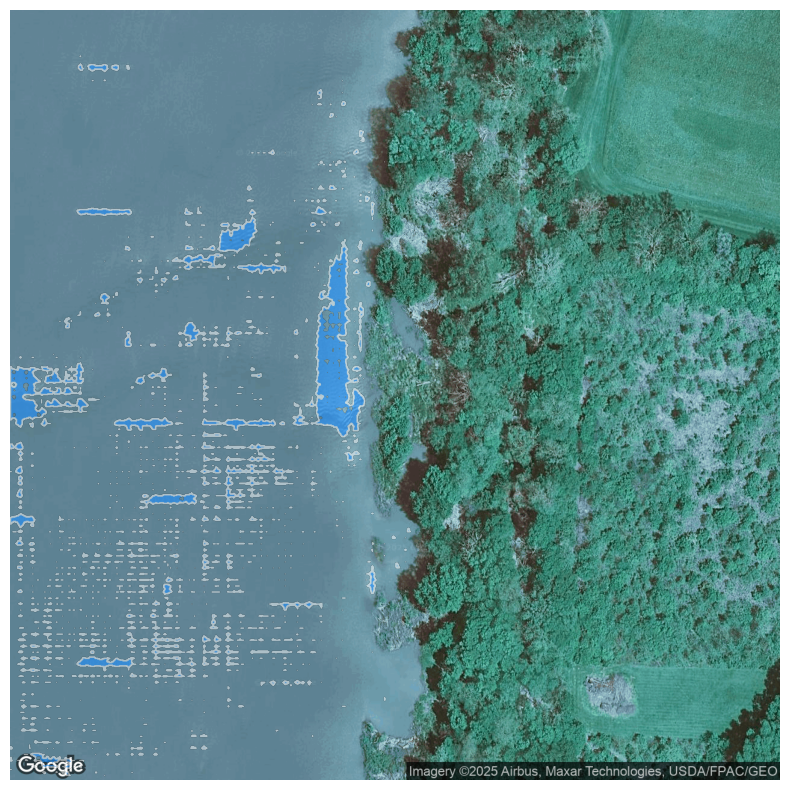

51630.0


In [11]:
from helper_functions import show_masks

pred_masks, scores, logits = predictMask(img, predictor)
show_masks(img, pred_masks, scores, borders=True)

print(np.sum(pred_masks))

# Training Routine

In [ ]:
# Allow the model to predict with no input points
input_point = np.empty((0, 2)) 
input_label = np.empty((0,), dtype=int)

num_epochs = 3
for epoch in range(num_epochs):
    sam2_model.train()
    # Loop through the training data
    for i in range(len(train_data)):
        img, mask = read_batch(train_data, i)
        optimizer.zero_grad()
        predictor.set_image(img)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)

        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
        )
        
        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )

        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        # Calculate the loss for the segmentation
        gt_mask = torch.tensor(mask.astype(np.float32)).to(device)
        prd_mask = torch.sigmoid(prd_masks[:, 0])
        seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

        # Calculate the loss for the score
        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()

        # Combine the two losses, segmentation loss has a much higher weight
        loss = seg_loss + score_loss * 0.05

        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            testLoss = []
            for j in range(len(test_data)):
                with torch.no_grad():
                    img, mask = read_batch(test_data, j)
                    predictor.set_image(img)
                    pred_masks, scores, logits = predictor.predict(
                        point_coords = input_point,
                        point_labels = input_label,
                        multimask_output = False
                    )

                    # Calculate the loss for the segmentation
                    gt_mask = torch.tensor(mask.astype(np.float32)).to(device)
                    prd_mask = torch.sigmoid(prd_masks[:, 0])
                    seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

                    # Calculate the loss for the score
                    inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
                    iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
                    score_loss = torch.abs(prd_scores[:, 0] - iou).mean()

                    # Combine the two losses, segmentation loss has a much higher weight
                    loss = seg_loss + score_loss * 0.05
                    testLoss.append(loss.item())
                    
            print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}, Test Loss: {np.mean(testLoss)}")

Epoch 0, Iteration 0, Loss: 0.5463752746582031, Test Loss: 0.5959408948054681
Epoch 0, Iteration 10, Loss: 0.5578048229217529, Test Loss: 0.8064896189249479
Epoch 0, Iteration 20, Loss: 1.772566795349121, Test Loss: 2.208331062243535
Epoch 0, Iteration 30, Loss: 0.8550274968147278, Test Loss: 0.8231240373391372
Epoch 0, Iteration 40, Loss: 0.6256981492042542, Test Loss: 0.6867856199924762
Epoch 0, Iteration 50, Loss: 0.7663867473602295, Test Loss: 0.9291223310507261
Epoch 1, Iteration 0, Loss: 0.730738639831543, Test Loss: 1.1680056681999793
Epoch 1, Iteration 10, Loss: 0.7892143130302429, Test Loss: 1.1251723720477178
Epoch 1, Iteration 20, Loss: 1.9500316381454468, Test Loss: 2.481591664827787
Epoch 1, Iteration 30, Loss: 1.2415176630020142, Test Loss: 1.181334293805636
Epoch 1, Iteration 40, Loss: 0.9896326065063477, Test Loss: 1.0886219235566945
Epoch 1, Iteration 50, Loss: 1.2414939403533936, Test Loss: 1.4492618281107683
Epoch 2, Iteration 0, Loss: 1.0178275108337402, Test Loss: 

In [17]:
# Save the model
torch.save(sam2_model.state_dict(), f"sam2_model_finetuned_epoch_{epoch + 1}.pt")

# Load the Trained Model

In [ ]:
# Define the pretrained model configuration you want to use
modelPath = f"sam2_model_finetuned_epoch_{epoch + 1}.pt"

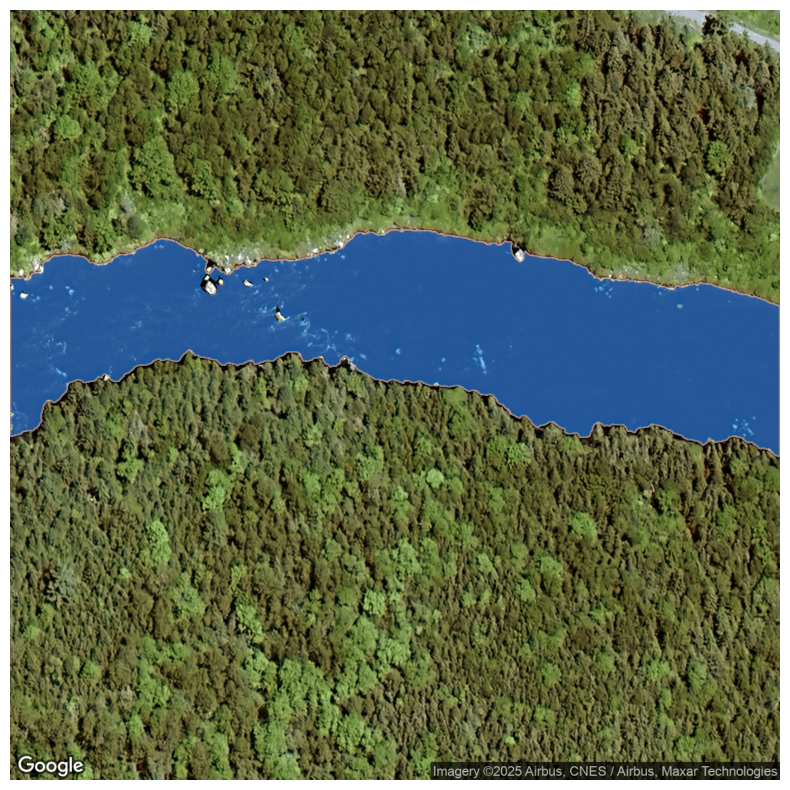

In [ ]:
# Reload the model as above (once training is complete and a model is saved, this chunk can be run on its own)
sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor1 = SAM2ImagePredictor(sam2_model)
# Load the model state that we trained
predictor1.model.load_state_dict(torch.load(rootPath + modelPath))

## Uncomment any of these lines to test the model on a specific image
## You may also replace the path with any other image you would like to test
img = cv2.imread(rootPath + "/8999_-66.80780964334836_45.25465155192838_z18.png")
# img = cv2.imread(rootPath + "36190_-77.98019272273278_37.62485835409872_z18.png")
# img = cv2.imread(rootPath + "43473_-75.20295287107768_44.06935181786453_z18.png")

pred_masks, scores, logits = predictMask(img, predictor1)
show_masks(img, pred_masks, scores, borders=True)